# Geometric Brownian Motion with Monte Carlo Sims on Real Life Data
## Plus Risk Analysis using Sortino Ratio, Maximum Drawdown, and Beta

This project uses mathematical models to simulate stock price behavior and measure risk. Starting with Geometric Brownian Motion (GBM) for individual stocks, we run Monte Carlo simulations and analyze portfolio risk using:

- **Sortino Ratio:** Focuses on downside risk.
- **Maximum Drawdown:** Largest drop from peak to trough.
- **Beta:** Sensitivity to market movements.
- **Probability of Loss:** The likelihood that the simulated final stock price is lower than the initial price. 

### What is Geometric Brownian Motion?

GBM is a standard model for stock prices, capturing both average growth (drift) and randomness (volatility). It’s a core tool for simulating realistic price paths in finance and Monte Carlo analysis.

#### Assumptions of GBM
- **Constant drift:** The average return of the stock is constant over time.
- **Constant volatility:** The degree of randomness or variability in returns is constant.
- **Log-normal distribution:** Stock prices are always positive and follow a log-normal distribution.

The formula for simulating the next stock price is:

$$
S_{t+1} = S_t \cdot \exp \left( \left( \mu - \frac{1}{2}\sigma^2 \right)\Delta t + \sigma W_t \right) \tag{1}
$$

**Where,**

$$
\begin{aligned}
S_t      & : \quad \text{Stock price at time } t \\
\mu      & : \quad \text{Average return (drift)} \\
\sigma   & : \quad \text{Volatility (how much the price varies)} \\
\Delta t & : \quad \text{Time step (e.g., 1/252 for daily steps)} \\
W_t      & : \quad \text{Random value from a standard Brownian motion (Wiener process) at time } t
\end{aligned}
$$

This formula updates the current stock price by accounting for both the expected growth (drift) and a random shock (volatility). The random component means each simulated path will look different, mimicking the unpredictable nature of real stock prices.

We will use GBM to generate many possible future stock price paths using Monte Carlo simulations. By simulating thousands of these paths, we can analyze the distribution of possible outcomes and assess risk using metrics like the Sortino Ratio, Maximum Drawdown, and

### Simulating Multiple GBM Paths

To explore the range of possible outcomes, we simulate many stock price paths using the GBM model. Here’s a step-by-step approach:

#### 1. Set Up Parameters

In [43]:
import numpy as np
import matplotlib.pyplot as plt

initial_price = 100      # S0
annual_drift = 0.1       # mu
annual_volatility = 0.3  # sigma
years = 1                # T
steps = 100              # n (time steps)
simulations = 100      # M (number of paths)

#### 2. Generate Time Grid and Brownian Motions


In [44]:
dt = years / steps
time_grid = np.linspace(0, years, steps + 1)

# Simulate Brownian increments and cumulative sum for each path
dW = np.random.normal(0, np.sqrt(dt), size=(simulations, steps))
W = np.cumsum(dW, axis=1)
W = np.hstack([np.zeros((simulations, 1)), W])  # Start at zero

The mathematical interpretation is:

- **Brownian increments:**
  $$
  \Delta W_{i, t} \sim \mathcal{N}(0,\, \Delta t)
  $$
  where $\Delta W_{i, t}$ is the increment for simulation $i$ at time $t$.

- **Cumulative Brownian motion:**
  $$
  W_{i, t} = \sum_{k=1}^{t} \Delta W_{i, k}
  $$
  where $W_{i, t}$ is the Wiener process for simulation $i$ at time $t$.

- **Initial condition:**
  $$
  W_{i, 0} = 0
  $$

#### 3. Calculate All Paths Using the Explicit Formula

In [45]:
# Vectorized calculation for all paths
drift = (annual_drift - 0.5 * annual_volatility**2) * time_grid
diffusion = annual_volatility * W
log_paths = drift + diffusion
S = initial_price * np.exp(log_paths)

#### 4. Plot the Simulated Stock Price Paths

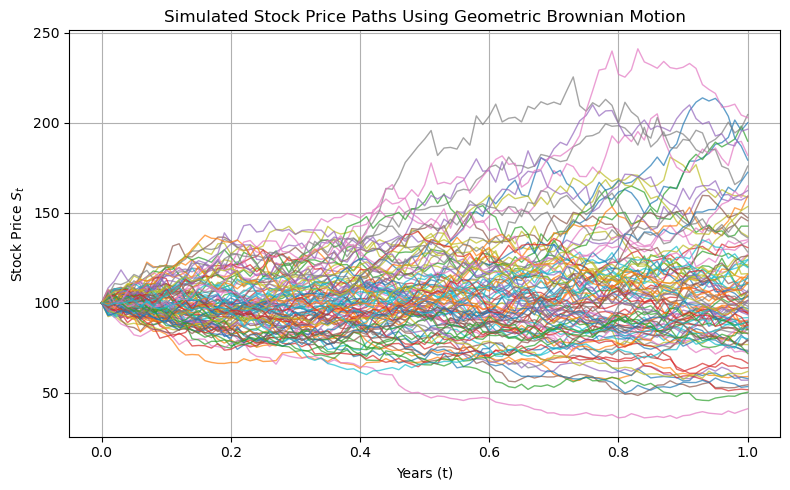

In [46]:
plt.figure(figsize=(8, 5))
plt.plot(time_grid, S.T, lw=1, alpha=0.7)
plt.xlabel("Years (t)")
plt.ylabel("Stock Price $S_t$")
plt.title("Simulated Stock Price Paths Using Geometric Brownian Motion")
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import gaussian_kde

1. **Download** historical stock data (SPY) and estimate drift/volatility.

In [48]:
ticker = "SPY"
data = yf.download(ticker, period="5y", auto_adjust=True)
prices = data['Close'].dropna()

[*********************100%***********************]  1 of 1 completed


2. **Simulate** 1000 possible price paths for 1 year using Geometric Brownian Motion (GBM).

In [49]:
log_returns = np.log(prices / prices.shift(1)).dropna()
annual_drift = log_returns.mean().item() * 252  # mu, use .item() for scalar
annual_volatility = log_returns.std().item() * np.sqrt(252)  # sigma, use .item() for scalar
initial_price = prices.iloc[-1].item()  # S, use .item() for scalar

3. **Calculate** daily returns for each path.

In [50]:
years = 1
steps = 252  # trading days in a year
simulations = 1000  # M (number of paths)
dt = years / steps  # time step size
time_grid = np.linspace(0, years, steps + 1)  # time grid for simulation

4. **Compute** three risk metrics for each simulation:

In [51]:
dW = np.random.normal(0, np.sqrt(dt), size=(simulations, steps))  # Brownian increments
W = np.cumsum(dW, axis=1)  # Cumulative sum to get Brownian motion
W = np.hstack([np.zeros((simulations, 1)), W])  # Start at zero
drift = (annual_drift - 0.5 * annual_volatility**2) * time_grid  # Drift term
diffusion = annual_volatility * W  # Diffusion term
log_paths = drift + diffusion  # Logarithmic paths
S = initial_price * np.exp(log_paths)  # Simulated stock prices

# Calculate probability of loss (final price < initial price)
final_prices = S[:, -1]
prob_loss = np.mean(final_prices < initial_price)

# Calculate daily returns for each path
returns = S[:, 1:] / S[:, :-1] - 1  

# Simulate market prices for comparison
market_W = np.cumsum(np.random.normal(0, np.sqrt(dt), steps))  # Market Brownian increments
market_S = initial_price * np.exp((annual_drift - 0.5 * annual_volatility**2) * time_grid + annual_volatility * np.hstack([[0], market_W]))  # Simulated market prices
market_returns = market_S[1:] / market_S[:-1] - 1  # Daily market returns

   #Sortino Ratio: Downside risk-adjusted return.
sortino_ratios = []
for i in range(simulations):
    r = returns[i]
    downside = r[r < 0]
    downside_std = np.std(downside) if len(downside) > 0 else 1e-8
    sortino = np.mean(r) / downside_std
    sortino_ratios.append(sortino)

   # Maximum Drawdown: Largest peak-to-trough loss.
max_drawdowns = []
for i in range(simulations):
    cumulative = np.maximum.accumulate(S[i])
    drawdown = (S[i] - cumulative) / cumulative
    max_drawdowns.append(drawdown.min())

   # Beta:*Sensitivity to a simulated market.
betas = []
for i in range(simulations):
    r = returns[i]
    cov = np.cov(r, market_returns)[0, 1]
    beta = cov / np.var(market_returns)
    betas.append(beta)

5. **Visualize** the distribution of each risk metric.

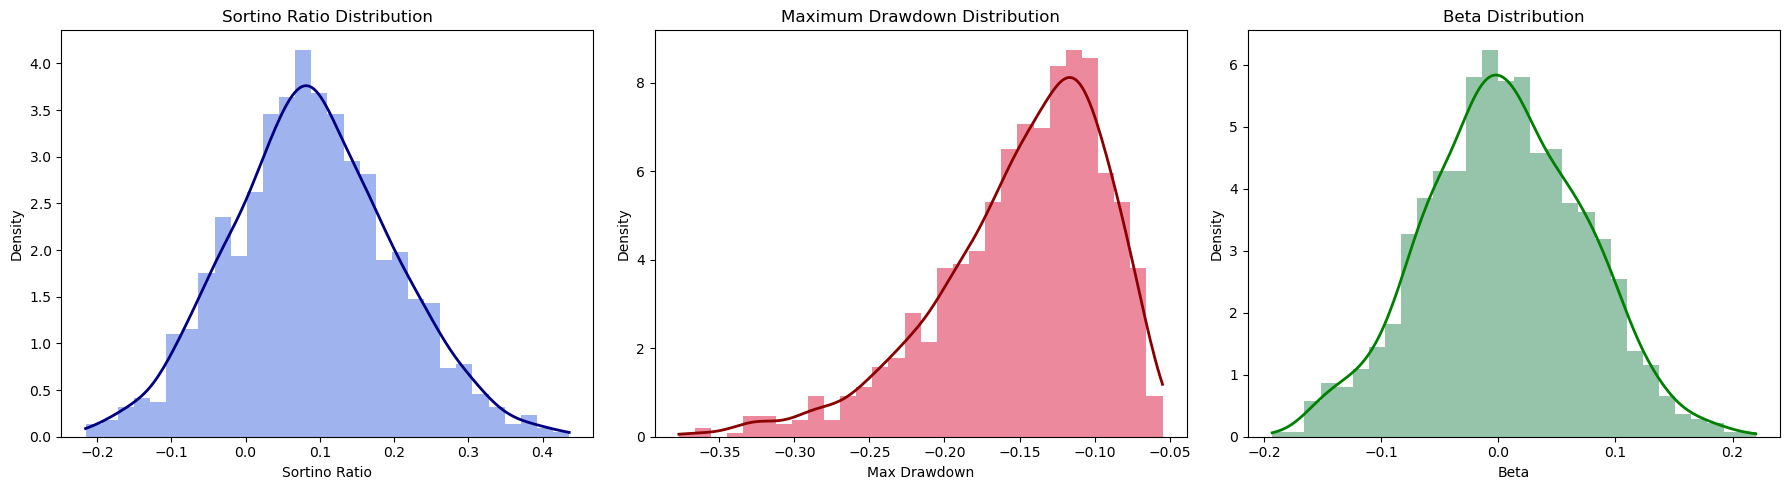

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Sortino Ratio
axs[0].hist(sortino_ratios, bins=30, color='royalblue', alpha=0.5, density=True)
kde = gaussian_kde(sortino_ratios)
x = np.linspace(min(sortino_ratios), max(sortino_ratios), 200)
axs[0].plot(x, kde(x), color='navy', lw=2)
axs[0].set_title('Sortino Ratio Distribution')
axs[0].set_xlabel('Sortino Ratio')
axs[0].set_ylabel('Density')

# Maximum Drawdown
axs[1].hist(max_drawdowns, bins=30, color='crimson', alpha=0.5, density=True)
kde = gaussian_kde(max_drawdowns)
x = np.linspace(min(max_drawdowns), max(max_drawdowns), 200)
axs[1].plot(x, kde(x), color='darkred', lw=2)
axs[1].set_title('Maximum Drawdown Distribution')
axs[1].set_xlabel('Max Drawdown')
axs[1].set_ylabel('Density')

# Beta
axs[2].hist(betas, bins=30, color='seagreen', alpha=0.5, density=True)
kde = gaussian_kde(betas)
x = np.linspace(min(betas), max(betas), 200)
axs[2].plot(x, kde(x), color='green', lw=2)
axs[2].set_title('Beta Distribution')
axs[2].set_xlabel('Beta')
axs[2].set_ylabel('Density')

plt.tight_layout()
plt.show()

### Distribution Analysis of Financial Metrics

#### **Sortino Ratio** by calculating the average return 

2> Excellent 
1 to 2: Good
< 1: Poor (more downside risk than return)
This suggests:
- Returns are consistent
- Losses are rare or mild
- The strategy is well-performing and relatively safe|

In [53]:
avg_returns = np.mean(returns, axis=0)
downside = avg_returns[avg_returns < 0]
downside_std = np.std(downside) if len(downside) > 0 else 1e-8
sortino_avg = np.mean(avg_returns) / downside_std
print('Sortino Ratio:', round(sortino_avg, 3))

Sortino Ratio: 3.021


### Maximum Drawdown

Maximum Drawdown is the largest observed loss from a peak to a trough during the simulation period.

- **Mean:** On average, the largest drawdown observed across all simulations.
- **Median:** The middle value of all drawdowns (half are worse, half are better).
- **Worst:** The single worst drawdown recorded (most severe loss).

This metric shows the potential severity of losses. A worst drawdown near -50% means nearly half the investment value was lost at the lowest point.

In [59]:
print('Maximum Drawdown:')
mean_dd = np.mean(max_drawdowns) * 100
median_dd = np.median(max_drawdowns) * 100
worst_dd = np.min(max_drawdowns) * 100
print(f'  Mean:   {mean_dd:.1f}%')
print(f'  Median: {median_dd:.1f}%')
print(f'  Worst:  {worst_dd:.1f}%')

Maximum Drawdown:
  Mean:   -14.8%
  Median: -13.7%
  Worst:  -37.7%


### Beta

Beta measures sensitivity to market movements (market risk exposure).

- **Beta ≈ 1:** Moves in line with the market  
- **Beta < 1:** Less volatile than the market  
- **Beta > 1:** More volatile than the market  
- **Beta ≈ 0:** Market-neutral (barely reacts to market)

A low beta means the investment moves very little relative to the market.  
This is typical for hedged strategies, cash-like investments, or non-equity assets.

In [61]:
beta_val = round(betas[0], 3)
print(f'Beta: {beta_val}')

Beta: 0.071


### Probability of Loss

The probability of loss is the percentage of simulations where the final price is below the initial price.  
This represents the chance of losing money over the period.

In [55]:
print('Probability of Loss:', round(prob_loss * 100, 2), '%')

Probability of Loss: 23.3 %
